In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [6]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Simple RNN Model with Learning Rate Scheduler

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
history = model.fit(train_dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 30ms/step - loss: 194.1704 - mae: 194.6704
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 188.7935 - mae: 189.2935
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 182.0599 - mae: 182.5599
Epoch 4/100
31/31 [==============================] - 1s 25ms/step - loss: 174.1143 - mae: 174.6143
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 164.5991 - mae: 165.0991
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 152.8415 - mae: 153.3415
Epoch 7/100
31/31 [==============================] - 1s 25ms/step - loss: 137.4901 - mae: 137.9901
Epoch 8/100
31/31 [==============================] - 1s 27ms/step - loss: 116.4441 - mae: 116.9441
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 87.3890 - mae: 87.8890
Epoch 10/100
31/31 [==============================] - 1s 40ms/step - loss: 49.9131 - mae: 50.4122
Epoch 11/100


31/31 [==============================] - 1s 29ms/step - loss: 14.3080 - mae: 14.7985
Epoch 86/100
31/31 [==============================] - 1s 48ms/step - loss: 23.1045 - mae: 23.6007
Epoch 87/100
31/31 [==============================] - 1s 28ms/step - loss: 16.0744 - mae: 16.5687
Epoch 88/100
31/31 [==============================] - 1s 29ms/step - loss: 20.5859 - mae: 21.0819
Epoch 89/100
31/31 [==============================] - 1s 28ms/step - loss: 15.4858 - mae: 15.9800
Epoch 90/100
31/31 [==============================] - 1s 28ms/step - loss: 16.5943 - mae: 17.0890
Epoch 91/100
31/31 [==============================] - 1s 27ms/step - loss: 13.9369 - mae: 14.4283
Epoch 92/100
31/31 [==============================] - 1s 28ms/step - loss: 12.1167 - mae: 12.6083
Epoch 93/100
31/31 [==============================] - 1s 27ms/step - loss: 15.2415 - mae: 15.7337
Epoch 94/100
31/31 [==============================] - 1s 26ms/step - loss: 20.1777 - mae: 20.6715
Epoch 95/100
31/31 [=============

(1e-08, 0.0001, 0.0, 30.0)

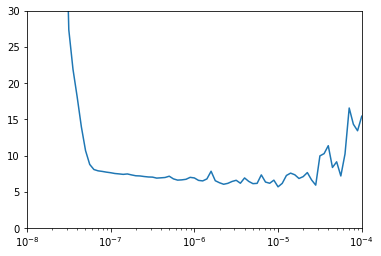

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 26ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 26ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 27ms/step - loss: 15.9200 - mae: 16.4144
Epoch 4/400
8/8 [==============================] - 0s 26ms/step - loss: 12.2879 - mae: 12.7814
Epoch 5/400
8/8 [==============================] - 0s 25ms/step - loss: 10.1501 - mae: 10.6403
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 16.3255 - mae: 16.8205
Epoch 7/400
8/8 [==============================] - 0s 26ms/step - loss: 13.5775 - mae: 14.0691
Epoch 8/400
8/8 [==============================] - 0s 26ms/step - loss: 9.4075 - mae: 9.8941
Epoch 9/400
8/8 [==============================] - 0s 25ms/step - loss: 7.0044 - mae: 7.4911
Epoch 10/400
8/8 [==============================] - 0s 25ms/step - loss: 16.9812 - mae: 17.4766
Epoch 11/400
8/8 [==============================] - 0

8/8 [==============================] - 0s 25ms/step - loss: 4.8966 - mae: 5.3749
Epoch 88/400
8/8 [==============================] - 0s 27ms/step - loss: 5.5874 - mae: 6.0671
Epoch 89/400
8/8 [==============================] - 0s 26ms/step - loss: 5.8493 - mae: 6.3343
Epoch 90/400
8/8 [==============================] - 0s 25ms/step - loss: 5.2932 - mae: 5.7728
Epoch 91/400
8/8 [==============================] - 0s 34ms/step - loss: 5.1882 - mae: 5.6708
Epoch 92/400
8/8 [==============================] - 0s 48ms/step - loss: 5.5681 - mae: 6.0492
Epoch 93/400
8/8 [==============================] - 0s 25ms/step - loss: 6.2947 - mae: 6.7773
Epoch 94/400
8/8 [==============================] - 0s 25ms/step - loss: 5.0683 - mae: 5.5494
Epoch 95/400
8/8 [==============================] - 0s 26ms/step - loss: 5.2385 - mae: 5.7170
Epoch 96/400
8/8 [==============================] - 0s 25ms/step - loss: 6.3886 - mae: 6.8701
Epoch 97/400
8/8 [==============================] - 0s 26ms/step - loss: 

8/8 [==============================] - 0s 26ms/step - loss: 5.0999 - mae: 5.5819
Epoch 174/400
8/8 [==============================] - 0s 28ms/step - loss: 5.1252 - mae: 5.6036
Epoch 175/400
8/8 [==============================] - 0s 26ms/step - loss: 4.8717 - mae: 5.3496
Epoch 176/400
8/8 [==============================] - 0s 25ms/step - loss: 4.8262 - mae: 5.3074
Epoch 177/400
8/8 [==============================] - 0s 23ms/step - loss: 4.5469 - mae: 5.0258
Epoch 178/400
8/8 [==============================] - 0s 26ms/step - loss: 4.7770 - mae: 5.2545
Epoch 179/400
8/8 [==============================] - 0s 25ms/step - loss: 5.4013 - mae: 5.8806
Epoch 180/400
8/8 [==============================] - 0s 24ms/step - loss: 4.9247 - mae: 5.4082
Epoch 181/400
8/8 [==============================] - 0s 24ms/step - loss: 4.2258 - mae: 4.7021
Epoch 182/400
8/8 [==============================] - 0s 23ms/step - loss: 4.3972 - mae: 4.8709
Epoch 183/400
8/8 [==============================] - 0s 26ms/ste

8/8 [==============================] - 0s 24ms/step - loss: 4.9413 - mae: 5.4209
Epoch 260/400
8/8 [==============================] - 0s 26ms/step - loss: 4.6805 - mae: 5.1559
Epoch 261/400
8/8 [==============================] - 0s 27ms/step - loss: 4.6076 - mae: 5.0841
Epoch 262/400
8/8 [==============================] - 0s 26ms/step - loss: 4.3495 - mae: 4.8266
Epoch 263/400
8/8 [==============================] - 0s 26ms/step - loss: 4.6591 - mae: 5.1311
Epoch 264/400
8/8 [==============================] - 0s 27ms/step - loss: 4.6039 - mae: 5.0812
Epoch 265/400
8/8 [==============================] - 0s 26ms/step - loss: 4.6830 - mae: 5.1616
Epoch 266/400
8/8 [==============================] - 0s 23ms/step - loss: 4.4282 - mae: 4.9010
Epoch 267/400
8/8 [==============================] - 0s 24ms/step - loss: 4.2267 - mae: 4.7035
Epoch 268/400
8/8 [==============================] - 0s 28ms/step - loss: 4.6454 - mae: 5.1242
Epoch 269/400
8/8 [==============================] - 0s 24ms/ste

8/8 [==============================] - 0s 27ms/step - loss: 5.0169 - mae: 5.4948
Epoch 346/400
8/8 [==============================] - 0s 25ms/step - loss: 4.3898 - mae: 4.8650
Epoch 347/400
8/8 [==============================] - 0s 27ms/step - loss: 5.1132 - mae: 5.5913
Epoch 348/400
8/8 [==============================] - 0s 26ms/step - loss: 4.9083 - mae: 5.3852
Epoch 349/400
8/8 [==============================] - 0s 25ms/step - loss: 4.6821 - mae: 5.1595
Epoch 350/400
8/8 [==============================] - 0s 27ms/step - loss: 4.2736 - mae: 4.7477
Epoch 351/400
8/8 [==============================] - 0s 40ms/step - loss: 5.0379 - mae: 5.5164
Epoch 352/400
8/8 [==============================] - 0s 49ms/step - loss: 5.7526 - mae: 6.2384
Epoch 353/400
8/8 [==============================] - 0s 26ms/step - loss: 5.1335 - mae: 5.6175
Epoch 354/400
8/8 [==============================] - 0s 26ms/step - loss: 4.4430 - mae: 4.9255
Epoch 355/400
8/8 [==============================] - 0s 26ms/ste

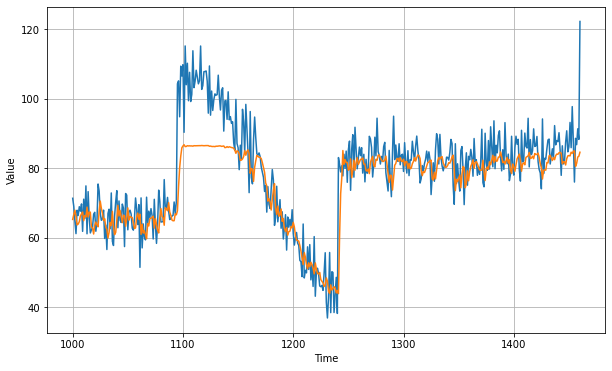

In [15]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.1490946

<Figure size 432x288 with 0 Axes>

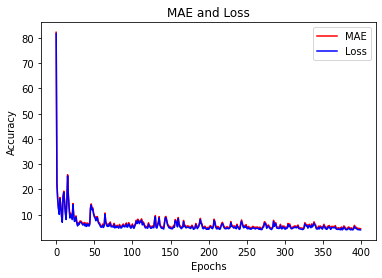

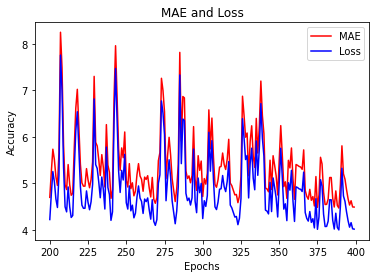

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Lstm

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 18.6358 - mae: 19.1300
Epoch 2/400
8/8 [==============================] - 0s 10ms/step - loss: 16.3909 - mae: 16.8866
Epoch 3/400
8/8 [==============================] - 0s 11ms/step - loss: 12.7596 - mae: 13.2493
Epoch 4/400
8/8 [==============================] - 0s 10ms/step - loss: 10.2689 - mae: 10.7556
Epoch 5/400
8/8 [==============================] - 0s 10ms/step - loss: 8.3474 - mae: 8.8347
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 7.8367 - mae: 8.3205
Epoch 7/400
8/8 [==============================] - 0s 10ms/step - loss: 7.4333 - mae: 7.9134
Epoch 8/400
8/8 [==============================] - 0s 10ms/step - loss: 6.9576 - mae: 7.4397
Epoch 9/400
8/8 [==============================] - 0s 9ms/step - loss: 6.9337 - mae: 7.4185
Epoch 10/400
8/8 [==============================] - 0s 10ms/step - loss: 6.7056 - mae: 7.1882
Epoch 11/400
8/8 [==============================] - 0s 10ms/st

8/8 [==============================] - 0s 10ms/step - loss: 4.5258 - mae: 5.0025
Epoch 89/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4821 - mae: 4.9566
Epoch 90/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4689 - mae: 4.9472
Epoch 91/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6313 - mae: 5.1079
Epoch 92/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6413 - mae: 5.1120
Epoch 93/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6517 - mae: 5.1263
Epoch 94/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6887 - mae: 5.1658
Epoch 95/400
8/8 [==============================] - 0s 20ms/step - loss: 4.7449 - mae: 5.2248
Epoch 96/400
8/8 [==============================] - 0s 16ms/step - loss: 4.6217 - mae: 5.0990
Epoch 97/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4565 - mae: 4.9277
Epoch 98/400
8/8 [==============================] - 0s 11ms/step - loss: 

8/8 [==============================] - 0s 10ms/step - loss: 4.3252 - mae: 4.7979
Epoch 175/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3571 - mae: 4.8277
Epoch 176/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4094 - mae: 4.8825
Epoch 177/400
8/8 [==============================] - 0s 11ms/step - loss: 4.4811 - mae: 4.9543
Epoch 178/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4277 - mae: 4.9031
Epoch 179/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3873 - mae: 4.8574
Epoch 180/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3651 - mae: 4.8368
Epoch 181/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4076 - mae: 4.8801
Epoch 182/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4079 - mae: 4.8799
Epoch 183/400
8/8 [==============================] - 0s 10ms/step - loss: 4.5080 - mae: 4.9863
Epoch 184/400
8/8 [==============================] - 0s 10ms/step

8/8 [==============================] - 0s 11ms/step - loss: 4.2987 - mae: 4.7720
Epoch 261/400
8/8 [==============================] - 0s 11ms/step - loss: 4.2805 - mae: 4.7553
Epoch 262/400
8/8 [==============================] - 0s 11ms/step - loss: 4.2778 - mae: 4.7508
Epoch 263/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3353 - mae: 4.8110
Epoch 264/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3393 - mae: 4.8117
Epoch 265/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3294 - mae: 4.8013
Epoch 266/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5233 - mae: 4.9988
Epoch 267/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3192 - mae: 4.7907
Epoch 268/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3430 - mae: 4.8188
Epoch 269/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3176 - mae: 4.7901
Epoch 270/400
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 10ms/step - loss: 4.3048 - mae: 4.7733
Epoch 347/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3227 - mae: 4.7943
Epoch 348/400
8/8 [==============================] - 0s 10ms/step - loss: 4.2619 - mae: 4.7338
Epoch 349/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4600 - mae: 4.9379
Epoch 350/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4870 - mae: 4.9615
Epoch 351/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2549 - mae: 4.7273
Epoch 352/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3828 - mae: 4.8534
Epoch 353/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3917 - mae: 4.8671
Epoch 354/400
8/8 [==============================] - 0s 10ms/step - loss: 4.2912 - mae: 4.7654
Epoch 355/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3211 - mae: 4.7934
Epoch 356/400
8/8 [==============================] - 0s 9ms/step 

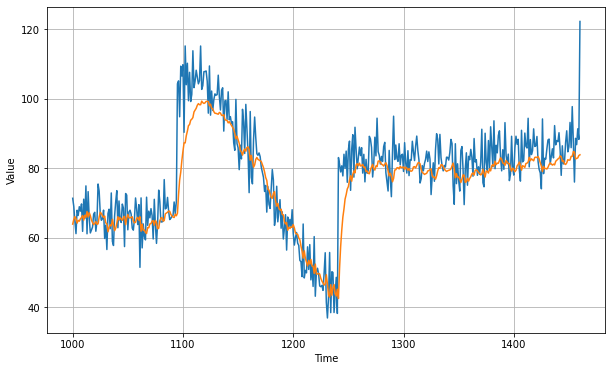

In [20]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

<Figure size 432x288 with 0 Axes>

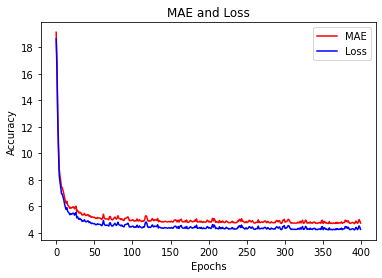

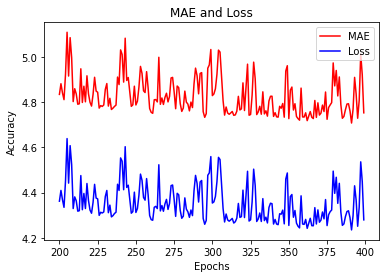

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()